In [56]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
left = cv2.imread('/content/drive/My Drive/A4_files/000020_left.jpg')
#left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
right = cv2.imread('/content/drive/My Drive/A4_files/000020_right.jpg')
#right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)

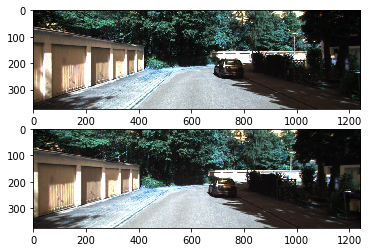

In [59]:
plt.subplot(2,1,1) 
plt.imshow(left)
plt.subplot(2,1,2) 
plt.imshow(right)

In [8]:
fl = open("/content/drive/My Drive/A4_files/000020.txt")
res = fl.readline()
res = res.split()
res

['Car', '685.05', '181.43', '804.68', '258.21']

In [9]:
# upper left point
start_point=(int(float(res[1])),int(float(res[2])))
# lower right point
end_point=(int(float(res[3])),int(float(res[4])))

print(start_point)
print(end_point)

(685, 181)
(804, 258)


In [10]:
fl = open("/content/drive/My Drive/A4_files/000020_allcalib.txt")
content = fl.readlines()
params = []
for line in content:
  params.append(float(line.rstrip('\n').split(" ")[1]))
params

[721.5377, 609.5593, 172.854, 0.5327119288]

In [0]:
patch_size = 5
f = params[0] 
px = params[1] 
py = params[2] 
baseline = params[3]

def compute_depth(x,y,padding_left,padding_right,patch_size,f,baseline):
  padding_left = padding_left.astype(float)
  padding_right = padding_right.astype(float)

  offset = (patch_size - 1)//2
  new_y = y + offset
  new_x = x + offset
  left_patch = padding_left[new_y-offset:new_y+offset+1,new_x-offset:new_x+offset+1,:]

  nc_max = -1
  x_target = -1
  for i in range(offset,new_x,2):
    temp_patch = padding_right[new_y-offset:new_y+offset+1,i-offset:i+offset+1,:]
    nc = np.sum((left_patch*temp_patch))/((np.sum(left_patch**2) * np.sum(temp_patch**2))**(1/2))
    if nc > nc_max or nc_max < 0:
      nc_max = nc
      x_target = i
  disparity = new_x - x_target
  depth = f*baseline/disparity
  return depth

height = end_point[1]+1 - start_point[1]
width = end_point[0]+1 - start_point[0]
depth_res = np.zeros((height,width))

# padding original image  
image_h,image_w,channel = left.shape[0],left.shape[1],left.shape[2]
padding_h = image_h + patch_size - 1
padding_w = image_w + patch_size - 1
offset = (patch_size- 1)//2
padding_left = np.zeros((padding_h,padding_w,channel),np.uint8)
padding_left[offset: (padding_h-offset),offset:(padding_w-offset),:] = left
padding_right = np.zeros((padding_h,padding_w,channel),np.uint8)
padding_right[offset: (padding_h-offset),offset:(padding_w-offset),:] = right


In [0]:
for i in range(start_point[1],end_point[1]+1):
  for j in range(start_point[0],end_point[0]+1):
    depth_res[i-start_point[1]][j-start_point[0]] = compute_depth(j,i,padding_left,padding_right,patch_size,f,baseline)

True

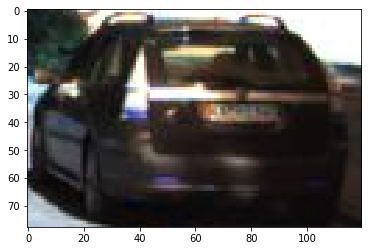

In [26]:
car = np.zeros((height,width,channel))
car = left[start_point[1]:end_point[1]+1,start_point[0]:end_point[0]+1,:]
plt.imshow(car)
cv2.imwrite("/content/drive/My Drive/car.jpg",car)

In [0]:
depth_normalize = depth_res/depth_res.max()
plt.figure(figsize=(24,64))
plt.imshow(depth_normalize)
plt.axis('off')

In [1]:
#!ls
%cd "./drive/My Drive/A4_files/GANet-master"
!ls

/content/drive/My Drive/A4_files/GANet-master
compile.sh     evaluation.sh	    libs     models	 README.md
dataloader     illustration	    LICENSE  predict.py  train.py
evaluation.py  kitti2015_final.pth  lists    predict.sh  train.sh


In [0]:
!chmod 755 ./compile.sh
!./compile.sh

In [0]:
import models.GANet_deep as gan
import torch
import torch.nn as nn
from torchvision.transforms import transforms as T
from PIL import Image

In [3]:
model = gan.GANet()
model = nn.DataParallel(model)
model.load_state_dict(torch.load("kitti2015_final.pth")["state_dict"])

left = Image.open("/content/drive/My Drive/A4_files/000020_left.jpg")
right = Image.open("/content/drive/My Drive/A4_files/000020_right.jpg")

transform = T.Compose([
    T.Resize((240,624)),
    T.ToTensor()
])

left = transform(left)
right = transform(right)
disp0, disp1, disp2 = model(torch.tensor(left).unsqueeze(0), torch.tensor(right).unsqueeze(0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legac

(-0.5, 1241.5, 374.5, -0.5)

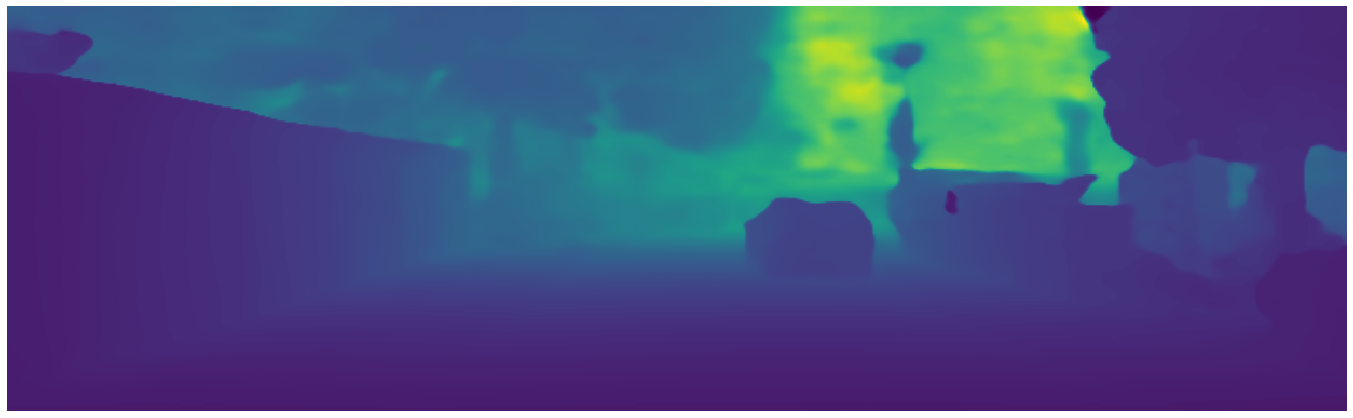

In [13]:
disp = disp2.cpu().detach().numpy().squeeze()
disp = cv2.resize(disp,(1242,375))
depth = (f*baseline)/disp

plt.figure(figsize=(24,64))
plt.imshow(depth)
plt.axis('off')

In [0]:
depth_box = depth[start_point[1]:end_point[1]+1,start_point[0]:end_point[0]+1]
depth_box = depth_box/depth_box.max()
plt.figure(figsize=(24,64))
plt.imshow(depth_box)
plt.axis('off')

In [0]:

def compute_3d_location(x,y,disp,px,py,f,baseline):
  Z = round(f*baseline/disp)
  X = round(Z*(x - px)/f)
  Y = round(Z*(y - py)/f)
  return X, Y, Z
def compute_distance(dis1,dis2):
  dis = ((dis1[0]-dis2[0])**2 + (dis1[1]-dis2[1])**2 + (dis1[2]-dis2[2])**2)**(1/2)
  return dis

In [21]:
box_center_x = start_point[0] + (end_point[0] - start_point[0])//2
print(box_center_x)
box_center_y = start_point[1] + (end_point[1] - start_point[1])//2
print(box_center_y)
box_center_disp = disp[box_center_y][box_center_x]
box_center_coordinate = compute_3d_location(box_center_x,box_center_y,box_center_disp,px,py,f,baseline)

car_pixel = []
car_pixel_2d = []
for i in range(start_point[1],end_point[1]+1):
  for j in range(start_point[0],end_point[0]+1):
    disparity = disp[i][j]
    coordinate_3d = compute_3d_location(j,i,disparity,px,py,f,baseline)
    if compute_distance(box_center_coordinate,coordinate_3d) < 3.5:
      car_pixel.append(coordinate_3d)
      car_pixel_2d.append((i-start_point[1],j-start_point[0]))

len(car_pixel)

744
219


8214

In [0]:
car_pixel = np.array(car_pixel)
max_X = np.max(car_pixel,0)[0]
max_Y = np.max(car_pixel,0)[1]
max_Z = np.max(car_pixel,0)[2]
min_X = np.min(car_pixel,0)[0]
min_Y = np.min(car_pixel,0)[1]
min_Z = np.min(car_pixel,0)[2]

point1 = (min_X,min_Y,min_Z)
point2 = (min_X,max_Y,min_Z)
point3 = (max_X,min_Y,min_Z)
point4 = (max_X,max_Y,min_Z)
point5 = (min_X,min_Y,max_Z)
point6 = (min_X,max_Y,max_Z)
point7 = (max_X,min_Y,max_Z)
point8 = (max_X,max_Y,max_Z)

points_3d = [point1,point2,point3,point4,point5,point6,point7,point8]
points_3d

[(3.0, 0.0, 25.0),
 (3.0, 3.0, 25.0),
 (7.0, 0.0, 25.0),
 (7.0, 3.0, 25.0),
 (3.0, 0.0, 29.0),
 (3.0, 3.0, 29.0),
 (7.0, 0.0, 29.0),
 (7.0, 3.0, 29.0)]

In [0]:
def compute_2d_location(coordinate,f,px,py):
  x = int(round(coordinate[0]*f/coordinate[2] + px))
  y = int(round(coordinate[1]*f/coordinate[2] + py))
  return x,y

points_2d = []
for i in range(8):
  points_2d.append(compute_2d_location(points_3d[i],f,px,py))
print(points_2d)

[(696, 173), (696, 259), (812, 173), (812, 259), (684, 173), (684, 247), (784, 173), (784, 247)]


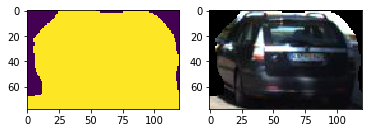

In [28]:
# draw segmentation
mask_w = end_point[0]+1 - start_point[0]
mask_h = end_point[1]+1 - start_point[1]
mask = np.zeros((mask_h,mask_w))
for i in range(len(car_pixel_2d)):
  y = car_pixel_2d[i][0]
  x = car_pixel_2d[i][1]
  mask[y][x]=1
plt.subplot(1,2,1) 
plt.imshow(mask)
plt.subplot(1,2,2)
car[mask==0,:] = 0
car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)
plt.imshow(car)

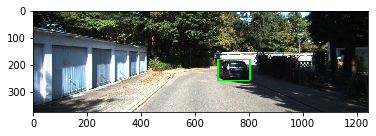

In [0]:
# draw bounding box
left = cv2.imread('/content/drive/My Drive/A4_files/000020_left.jpg')
left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
cv2.rectangle(left, start_point, end_point, (0,255,0),3)
plt.imshow(left)

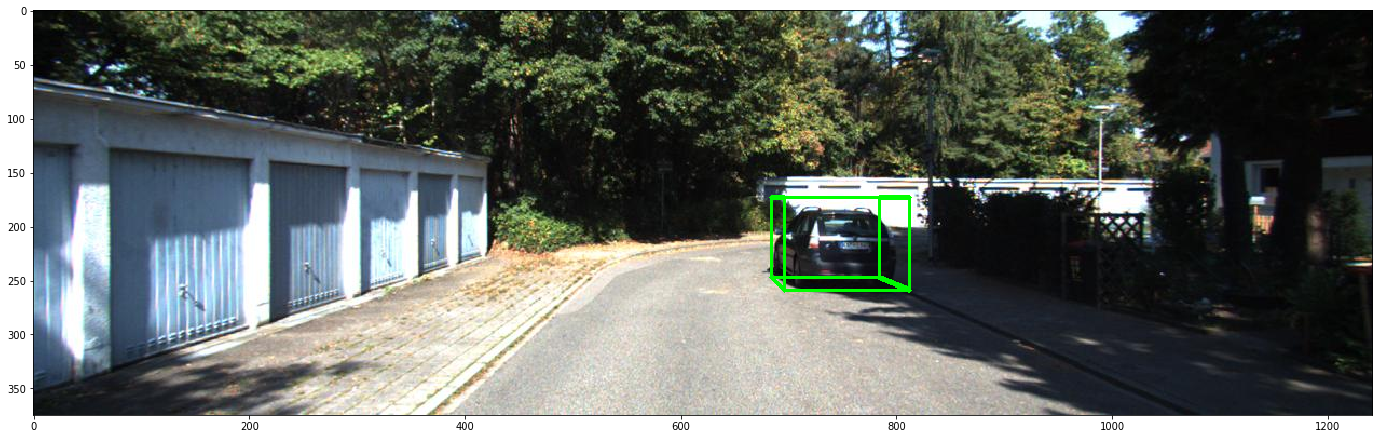

In [0]:
def draw_3D(img,points_2d):
  cv2.rectangle(img, points_2d[1], points_2d[2], (0,255,0),2)
  cv2.rectangle(img, points_2d[5], points_2d[6], (0,255,0),2)
  cv2.line(img,points_2d[0], points_2d[4],(0,255,0),3)
  cv2.line(img,points_2d[1],points_2d[5],(0,255,0),3)
  cv2.line(img,points_2d[2],points_2d[6],(0,255,0),3)
  cv2.line(img,points_2d[3],points_2d[7],(0,255,0),3)
  plt.figure(figsize=(24,64))
  plt.imshow(img)
left = cv2.imread('/content/drive/My Drive/A4_files/000020_left.jpg')
left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
draw_3D(left,points_2d)

In [0]:
# resize original image to find better interesting point
img1 = cv2.imread('/content/drive/My Drive/A4_files/I1.jpg')
h,w,c = img1.shape
h_new = int(h*0.2)
w_new = int(w*0.2)
img1 = cv2.resize(img1, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
img2 = cv2.imread('/content/drive/My Drive/A4_files/I2.jpg')
img2 = cv2.resize(img2, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
img3 = cv2.imread('/content/drive/My Drive/A4_files/I3.jpg')
img3 = cv2.resize(img3, (w_new, h_new), interpolation=cv2.INTER_CUBIC)

In [0]:
def point_distance(pt,pts):
  distance_list = []
  for i in range(len(pts)):
    target = pts[i]
    distance = ((pt[0]-target[0])**2+(pt[1]-target[1])**2)**(1/2)
    distance_list.append(distance)
  if len(pts)!=0 and min(distance_list) < 80:
    return True
  return False


In [0]:
def sift_matching(img1,img2,threshold,norm_type):
  sift = cv2.xfeatures2d.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img1,None)
  kp2, des2 = sift.detectAndCompute(img2,None)
  matched_pair = {}
  for i in range(len(kp1)):
    difference = des1[i,:] - des2
    differnece_abs = np.abs(difference)
    if norm_type == 1: #L1 norm
      res = np.sum(differnece_abs,axis=1)
    elif norm_type == 2: #L2 norm
      res_sum = np.sum(differnece_abs**2,axis=1)
      res = res_sum**(1/2)
    elif norm_type == 3: #L3 norm
      res_sum = np.sum(differnece_abs**3,axis=1)
      res = res_sum**(1/3)
    index_sorted = np.argsort(res)[:2]
    smallest = index_sorted[0]
    second_smallest = index_sorted[1]
    ratio = res[smallest] / res[second_smallest]
    if ratio < threshold:
      matched_pair[ratio] = (kp1[i],kp2[smallest])

  return matched_pair
def find_kp(result,num_match):
  points_in_img1 = []
  points_coordinate_img1 = []
  points_in_img2 = []
  points_coordinate_img2 = []
  count = 0
  for key in sorted(result):
    if count == num_match:
      break
    img1_pt = (int(result[key][0].pt[0]),int(result[key][0].pt[1]))
    img2_pt = (int(result[key][1].pt[0]),int(result[key][1].pt[1]))
    if img1_pt not in points_coordinate_img1:
      # commmented code for making matching points distributed over
      # the images and remove outliers between image1 and image3
      # if point_distance(img1_pt,points_coordinate_img1):
      #   continue
      # if img1_pt[0] > 750 or img1_pt[0]==44:
      #   continue
      points_in_img1.append(result[key][0])
      points_coordinate_img1.append(img1_pt)
      points_in_img2.append(result[key][1])
      points_coordinate_img2.append(img2_pt)
      count += 1
  return points_in_img1,points_coordinate_img1,points_in_img2,points_coordinate_img2

In [0]:
img1 = cv2.imread('/content/drive/My Drive/A4_files/I1.jpg')
img1 = cv2.resize(img1, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
img2 = cv2.imread('/content/drive/My Drive/A4_files/I2.jpg')
img2 = cv2.resize(img2, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
result = sift_matching(img1,img2,0.8,2)
points_in_img1,points_coordinate_img1,points_in_img2,points_coordinate_img2 = find_kp(result,8)

In [0]:
res1 = cv2.drawKeypoints(img1,points_in_img1,None,color=(0,0,255))

In [0]:
res2 = cv2.drawKeypoints(img2,points_in_img2,None,color=(0,0,255))

In [0]:
def draw_lines(new_res,new_res2,points_coordinate_img1,points_coordinate_img2,num_match):
  offset = new_res.shape[1]
  combine_image = np.concatenate((new_res,new_res2),axis = 1)
  for i in range(num_match):
    coordinate1_x = int(points_coordinate_img1[i][0])
    coordinate1_y = int(points_coordinate_img1[i][1])
    coordinate1 = (coordinate1_x,coordinate1_y)
    coordinate2_x = int(points_coordinate_img2[i][0] + offset)
    coordinate2_y = int(points_coordinate_img2[i][1])
    coordinate2 = (coordinate2_x, coordinate2_y)
    cv2.line(combine_image,coordinate1,coordinate2,(0,255,0),2)
  cv2.imwrite("/content/drive/My Drive/combine0.jpg",combine_image)


In [0]:
draw_lines(res1,res2,points_coordinate_img1,points_coordinate_img2,8)

In [0]:
img1 = cv2.imread('/content/drive/My Drive/A4_files/I1.jpg')
img1 = cv2.resize(img1, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
img3 = cv2.imread('/content/drive/My Drive/A4_files/I3.jpg')
img3 = cv2.resize(img3, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
result = sift_matching(img1,img3,0.8,2)
points_in_img1_1,points_coordinate_img1_1,points_in_img3,points_coordinate_img3 = find_kp(result,8)

In [0]:
points_coordinate_img1_1

[(454, 117),
 (245, 139),
 (425, 225),
 (48, 208),
 (645, 321),
 (706, 228),
 (227, 439),
 (625, 222)]

In [0]:
res1 = cv2.drawKeypoints(img1,points_in_img1_1,None,color=(0,0,255))
#cv2.imwrite("/content/drive/My Drive/1_5.jpg",res1)

In [0]:
res2 = cv2.drawKeypoints(img3,points_in_img3,None,color=(0,0,255))
#cv2.imwrite("/content/drive/My Drive/2_5.jpg",res2)

In [0]:
draw_lines(res1,res2,points_coordinate_img1_1,points_coordinate_img3,8)

In [0]:
def compute_fundamental_matrix(points_coordinate_img1,points_coordinate_img2):
  a = np.zeros((8,9))
  for i in range(8):
    x_l = points_coordinate_img1[i][0]
    y_l = points_coordinate_img1[i][1]
    x_r = points_coordinate_img2[i][0]
    y_r = points_coordinate_img2[i][1]
    item1 = x_r*x_l
    item2 = x_r*y_l
    item3 = x_r
    item4 = y_r*x_l
    item5 = y_r*y_l
    item6 = y_r
    item7 = x_l
    item8 = y_l
    item9 = 1
    a[i,:] = np.array([item1,item2,item3,item4,item5,item6,item7,item8,item9])
  u, s, v = np.linalg.svd(a)
  F1 = np.reshape(v[-1],(3,3))
  u1,s1,v1 = np.linalg.svd(F1)
  diagonal_value = np.array([s1[0],s1[1],0])
  new_s1 = np.diag(diagonal_value)
  F_res = u1.dot(new_s1).dot(v1)
  print(F_res)
  return F_res


In [0]:
F12 = compute_fundamental_matrix(np.int64(points_coordinate_img1),np.int64(points_coordinate_img2))

[[ 3.17752531e-07 -6.06694868e-07 -4.58488037e-04]
 [ 7.06874835e-07 -1.67485606e-07 -4.74372906e-03]
 [-2.09670332e-03  4.64629040e-03  9.99975651e-01]]


In [0]:
F13 = compute_fundamental_matrix(np.int64(points_coordinate_img1_1),np.int64(points_coordinate_img3))

[[ 4.99112174e-06 -7.37597339e-05 -8.76870928e-03]
 [-2.26540573e-05 -2.36791385e-06  1.70975687e-01]
 [ 6.12405689e-03 -1.20669244e-01  9.77799493e-01]]


In [0]:
def compute_epipolar_lines(points,F,img):
  lines = []
  for i in range(8):
    point_x = points[i][0]
    point_y = points[i][1]
    point = np.array([point_x,point_y,1])
    line = F.dot(point)
    lines.append(line)
  h,w,c = img.shape
  for i in range(8):
    point_1_x = 0
    point_2_x = w
    a = lines[i][0]
    b = lines[i][1]
    c = lines[i][2]
    point_1_y = (-a*point_1_x-c)/b
    point_2_y = (-a*point_2_x-c)/b
    point1 = (int(point_1_x), int(point_1_y))
    point2 = (int(point_2_x), int(point_2_y))
    cv2.line(img,point1,point2,(0,255,0),2)
    #cv2.imwrite("/content/drive/My Drive/output13.jpg",img)
  plt.imshow(img)
    

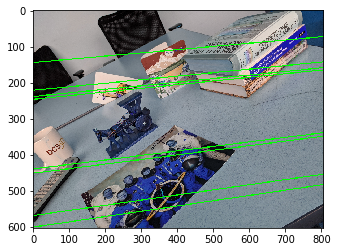

In [0]:
img2 = cv2.imread('/content/drive/My Drive/A4_files/I2.jpg')
img2 = cv2.resize(img2, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
compute_epipolar_lines(points_coordinate_img1,F12,img2)

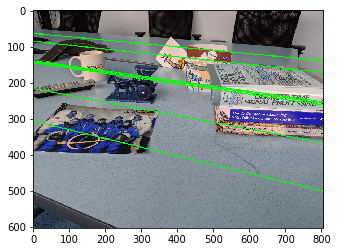

In [0]:
img3 = cv2.imread('/content/drive/My Drive/A4_files/I3.jpg')
img3 = cv2.resize(img3, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
compute_epipolar_lines(points_coordinate_img1_1,F13,img3)

True

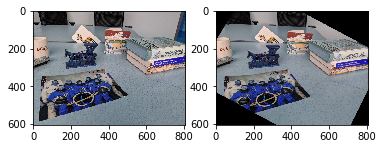

In [0]:
img1_1 = cv2.imread('/content/drive/My Drive/A4_files/I1.jpg')
img1_1 = cv2.resize(img1_1, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
plt.subplot(1,2,1) 
plt.imshow(img1_1)
img2_1 = cv2.imread('/content/drive/My Drive/A4_files/I2.jpg')
img2_1 = cv2.resize(img2_1, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.array(points_coordinate_img1),np.array(points_coordinate_img2),F12,(w_new,h_new))
H_r_12 = np.linalg.inv(H1).dot(H2)
im_dst = cv2.warpPerspective(img2_1, H_r_12, (w_new,h_new))
plt.subplot(1,2,2) 
plt.imshow(im_dst)
cv2.imwrite("/content/drive/My Drive/ref12_reference.jpg",img1_1)
cv2.imwrite("/content/drive/My Drive/ref12.jpg",im_dst)

True

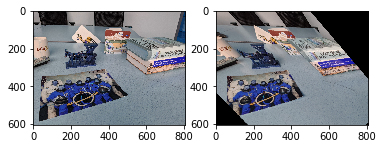

In [0]:
img3_1 = cv2.imread('/content/drive/My Drive/A4_files/I3.jpg')
img3_1 = cv2.resize(img3_1, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
_, H1, H3 = cv2.stereoRectifyUncalibrated(np.array(points_coordinate_img1_1),np.array(points_coordinate_img3),F13,(w_new,h_new))
H_r_13 = np.linalg.inv(H1).dot(H3)
im_dst_1 = cv2.warpPerspective(img3_1, H_r_13, (w_new,h_new))
plt.subplot(1,2,1) 
plt.imshow(img1_1)
plt.subplot(1,2,2) 
plt.imshow(im_dst_1)
cv2.imwrite("/content/drive/My Drive/ref13.jpg",im_dst_1)

In [0]:
F12_cv2,mask= cv2.findFundamentalMat(np.int64(points_coordinate_img1),np.int64(points_coordinate_img2),cv2.FM_8POINT)
F12_cv2

array([[ 3.12198219e-07, -6.17041154e-07, -4.17708828e-04],
       [ 7.22250357e-07, -1.68396137e-07, -4.82069738e-03],
       [-2.09505481e-03,  4.72976324e-03,  1.00000000e+00]])

In [0]:
F13_cv2,mask= cv2.findFundamentalMat(np.int64(points_coordinate_img1_1),np.int64(points_coordinate_img3),cv2.FM_8POINT)
F13_cv2

array([[ 2.73083625e-06, -4.66864999e-05, -6.36936019e-03],
       [-1.41229128e-05, -1.49911049e-06,  1.07844301e-01],
       [ 2.95902667e-03, -7.62157341e-02,  1.00000000e+00]])

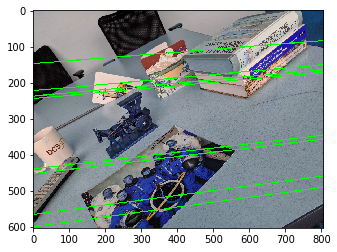

In [0]:
img2_new = cv2.imread('/content/drive/My Drive/A4_files/I2.jpg')
img2_new = cv2.resize(img2_new, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
compute_epipolar_lines(points_coordinate_img1,F12_cv2,img2_new)

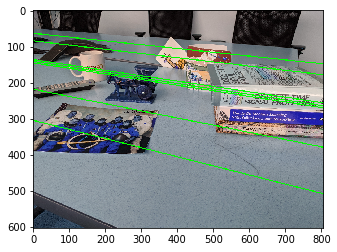

In [0]:
img3_new = cv2.imread('/content/drive/My Drive/A4_files/I3.jpg')
img3_new = cv2.resize(img3_new, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
compute_epipolar_lines(points_coordinate_img1_1,F13_cv2,img3_new)

True

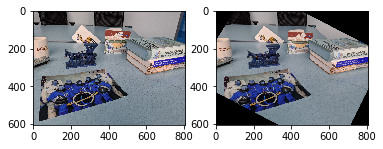

In [0]:
img1_2 = cv2.imread('/content/drive/My Drive/A4_files/I1.jpg')
img1_2 = cv2.resize(img1_2, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
plt.subplot(1,2,1) 
plt.imshow(img1_1)
img2_2 = cv2.imread('/content/drive/My Drive/A4_files/I2.jpg')
img2_2 = cv2.resize(img2_2, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
_, H1, H2 = cv2.stereoRectifyUncalibrated(np.array(points_coordinate_img1),np.array(points_coordinate_img2),F12_cv2,(w_new,h_new))
H_r_12 = np.linalg.inv(H1).dot(H2)
im_dst = cv2.warpPerspective(img2_2, H_r_12, (w_new,h_new))
plt.subplot(1,2,2) 
plt.imshow(im_dst)
cv2.imwrite("/content/drive/My Drive/ref122.jpg",im_dst)

True

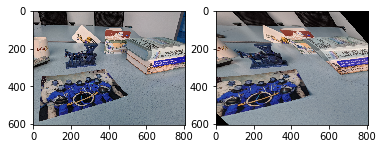

In [0]:
img3_2 = cv2.imread('/content/drive/My Drive/A4_files/I3.jpg')
img3_2 = cv2.resize(img3_2, (w_new, h_new), interpolation=cv2.INTER_CUBIC)
_, H1, H3 = cv2.stereoRectifyUncalibrated(np.array(points_coordinate_img1_1),np.array(points_coordinate_img3),F13_cv2,(w_new,h_new))
H_r_13 = np.linalg.inv(H1).dot(H3)
im_dst_1 = cv2.warpPerspective(img3_2, H_r_13, (w_new,h_new))
plt.subplot(1,2,1) 
plt.imshow(img1_1)
plt.subplot(1,2,2) 
plt.imshow(im_dst_1)
cv2.imwrite("/content/drive/My Drive/fff.jpg",im_dst_1)